In [ ]:
# load the libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# load data
candidate1_tweets = pd.read_csv("seanhannity_tweets.csv")
candidate2_tweets = pd.read_csv("jbouie_tweets.csv")

In [ ]:
# clean text data
def clean_text(text):
    # replace NaN values with empty strings
    if isinstance(text, float) and np.isnan(text):
        text = ""
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove digits
    text = re.sub(r"\d+", "", text)
    # convert to lowercase and remove leading/trailing whitespace
    text = text.lower().strip()
    # replace consecutive whitespace with a single space
    text = re.sub(r"\s+", " ", text)

    text = re.sub(r"http\S+", "", text) # remove URLs
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text) # remove non-alphanumeric characters
    text = re.sub(r"\b\w{1,2}\b", "", text) # remove short words
    
    return text

candidate1_tweets["text_clean"] = candidate1_tweets["text"].apply(clean_text)
candidate2_tweets["text_clean"] = candidate2_tweets["text"].apply(clean_text)

# replace NaN values with empty strings
candidate1_tweets["text_clean"].fillna("", inplace=True)
candidate2_tweets["text_clean"].fillna("", inplace=True)

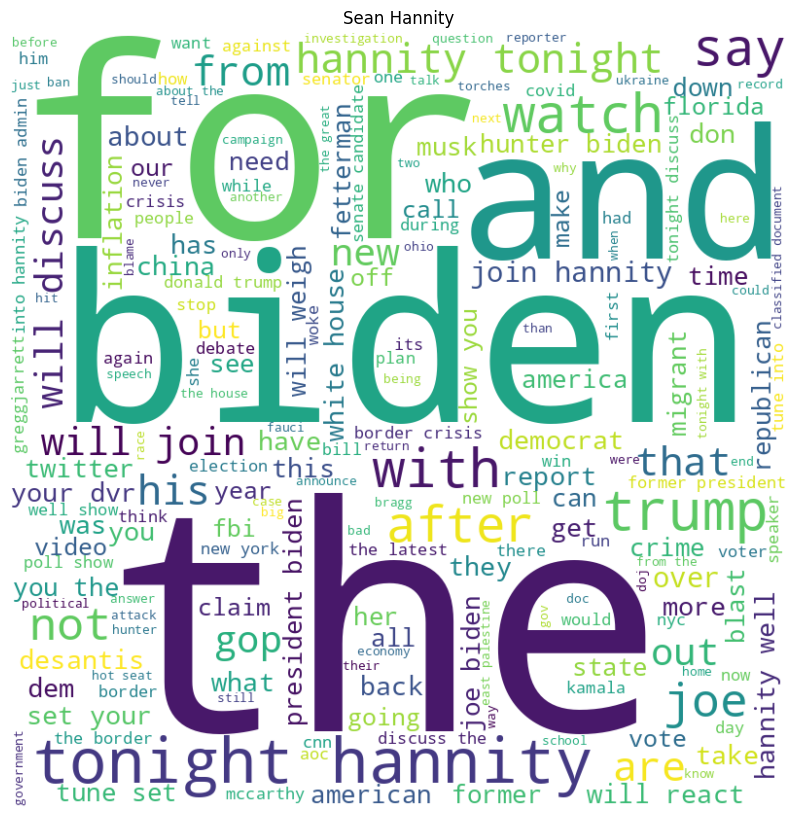

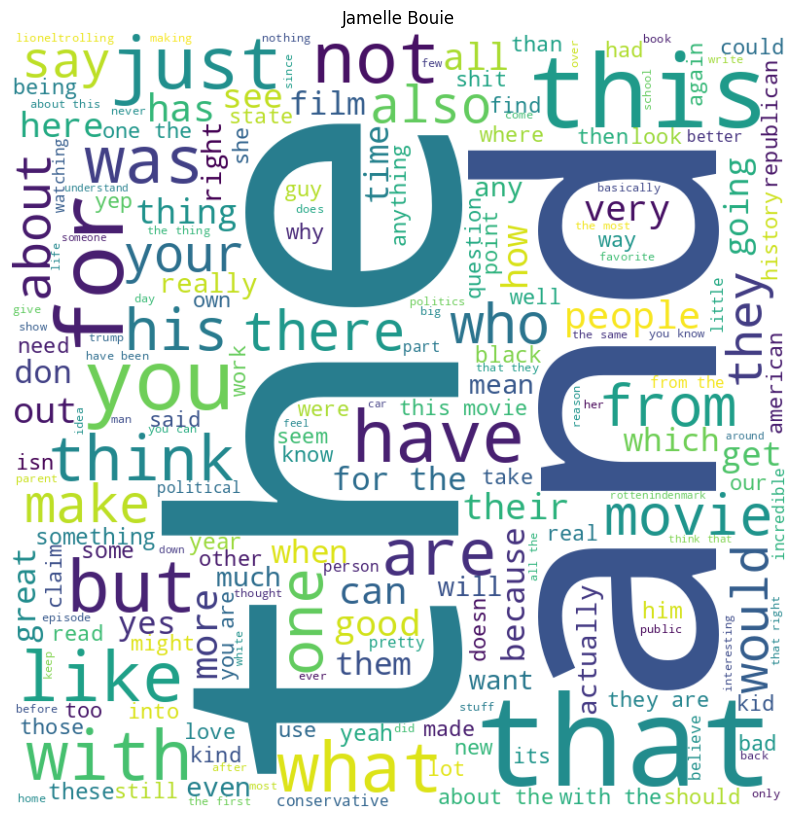

In [ ]:
# create word clouds
wordcloud1 = WordCloud(width = 800, height = 800, background_color ='white', 
                       stopwords = set(), min_font_size = 10).generate(' '.join(candidate1_tweets["text_clean"]))
wordcloud2 = WordCloud(width = 800, height = 800, background_color ='white', 
                       stopwords = set(), min_font_size = 10).generate(' '.join(candidate2_tweets["text_clean"]))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud1, interpolation='bilinear') 
plt.axis("off") 
plt.title("Sean Hannity")
plt.tight_layout(pad = 0) 
plt.show()

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud2,  interpolation='bilinear') 
plt.axis("off") 
plt.title("Jamelle Bouie")
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
def visualize_term_freqs(df, candidate):
    # Generate a count of each term in the cleaned text
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df["text_clean"])
    freqs = np.array(np.sum(X, axis=0))[0]
    terms = vectorizer.get_feature_names_out()
    # Create a DataFrame to hold the term and frequency data
    term_freq_df = pd.DataFrame({"term": terms, "freq": freqs})
    # Sort by frequency
    term_freq_df = term_freq_df.sort_values(by="freq", ascending=False)
    # Plot bar chart of the top 20 terms
    plt.figure(figsize=(10, 6))
    plt.bar(x=term_freq_df["term"][:20], height=term_freq_df["freq"][:20])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Term Frequencies for {candidate}")

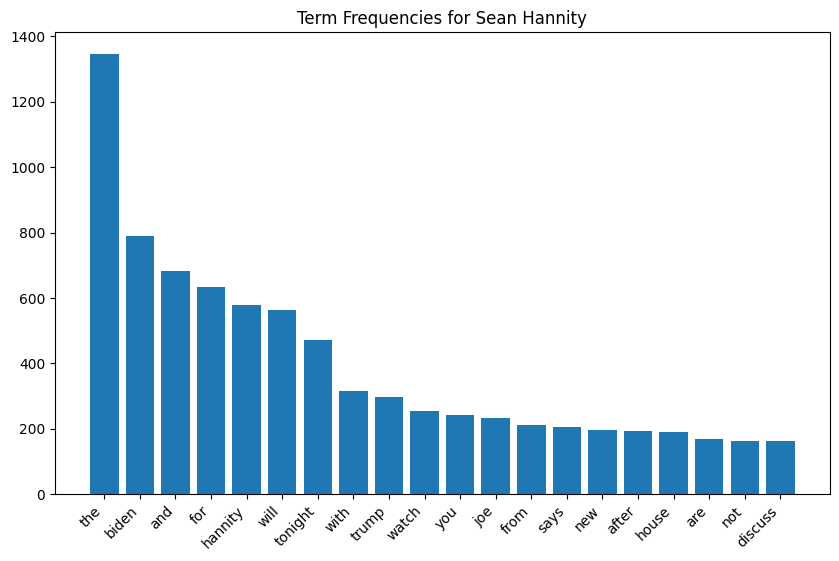

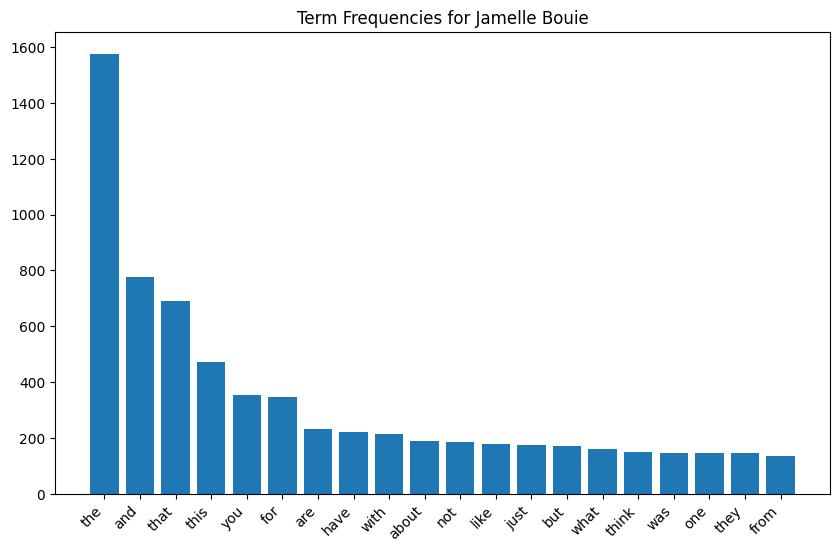

In [ ]:
# create term frequency plots
visualize_term_freqs(candidate1_tweets, "Sean Hannity")
visualize_term_freqs(candidate2_tweets, "Jamelle Bouie")

In [ ]:
# create document-term matrix
candidate1_tweets['tweeter'] = 'Sean Hannity'
candidate2_tweets['tweeter'] = 'Jamelle Bouie'

data = pd.concat([candidate1_tweets, candidate2_tweets], ignore_index=True)


In [ ]:
X = data.drop('tweeter', axis=1)
y = data['tweeter']
y_binary = np.where(y == 'Sean Hannity', 0, 1)
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(X["text_clean"])

In [ ]:
# Perform Variable Selection

kbest = SelectKBest(chi2, k=1000)
X_kbest = kbest.fit_transform(X, y_binary)

In [ ]:
# split data into train-test subsets
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y_binary, test_size=0.2, random_state=42)

# build logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Build logistic regression model with variable selection
model = LogisticRegression()
model.fit(X_train, y_train)
print('Model accuracy on test set:', model.score(X_test, y_test))

Model accuracy on test set: 0.9301227573182247


In [ ]:
# Get the test statistic and p-value for each term's coefficient
feature_names = vectorizer.get_feature_names_out()
selected_features = np.array(feature_names)[kbest.get_support()]
coefs = pd.DataFrame({'test_statistic': model.coef_[0], 'p_value': [2 * (1 - norm.cdf(abs(x))) for x in model.coef_[0]]}, index=selected_features)


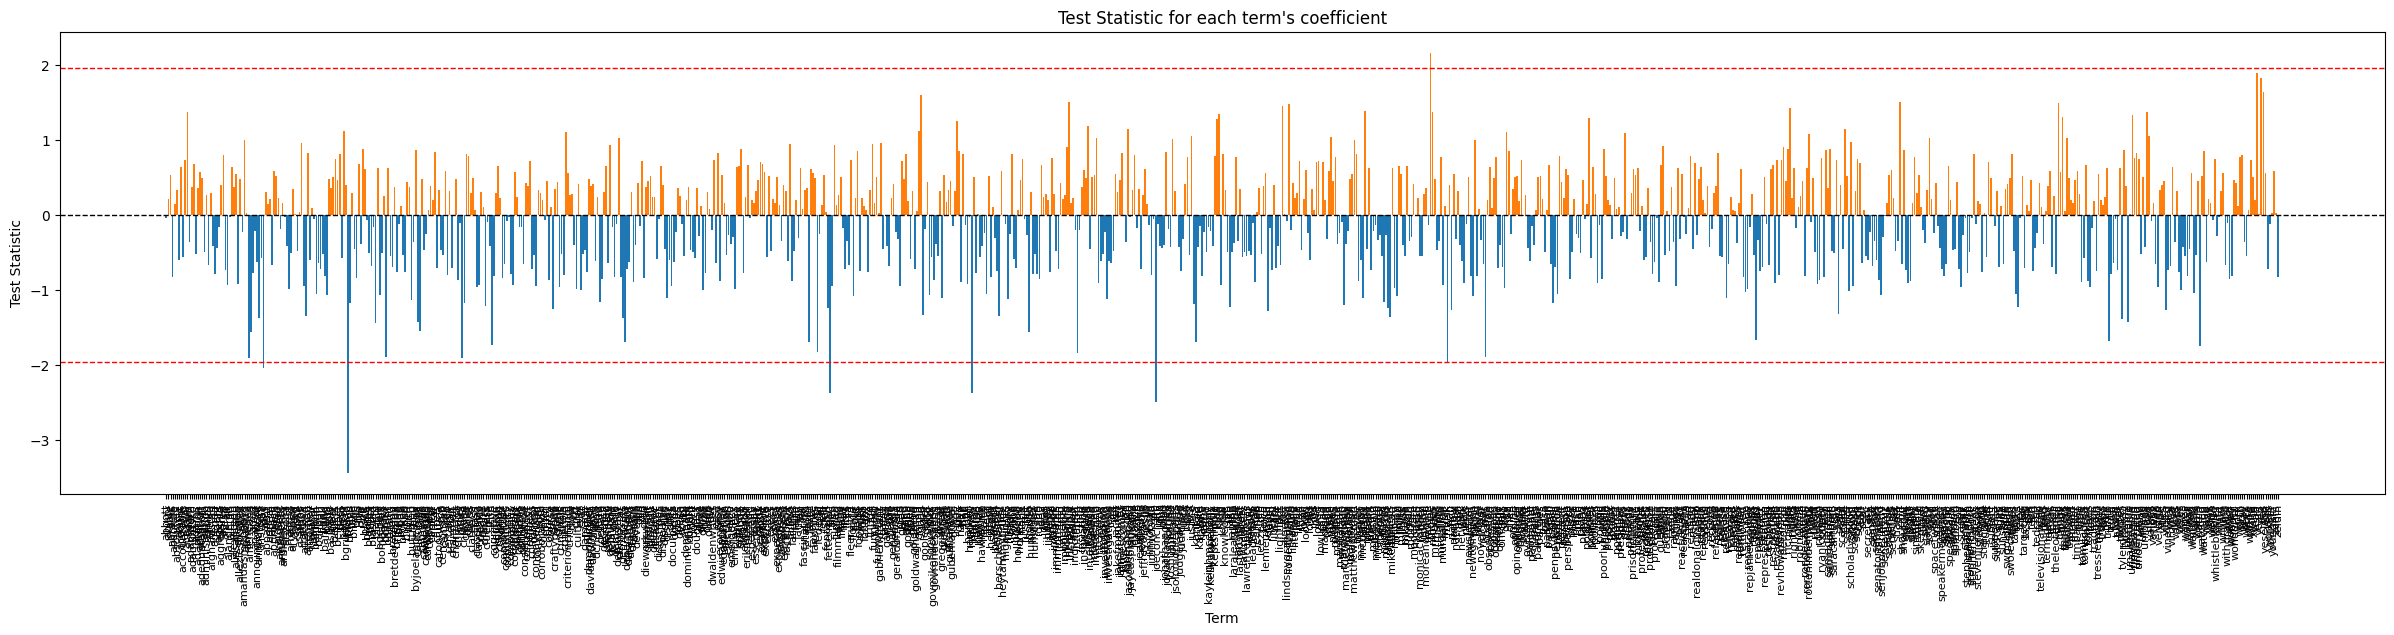

In [43]:
# Visualize the test statistic
fig, ax = plt.subplots(figsize=(30, 6))
colors = ['C0' if x < 0 else 'C1' for x in coefs['test_statistic']]
ax.bar(coefs.index, coefs['test_statistic'], color=colors)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.axhline(y=1.96, color='r', linestyle='--', linewidth=1)
ax.axhline(y=-1.96, color='r', linestyle='--', linewidth=1)
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title('Test Statistic for each term\'s coefficient')
ax.set_xlabel('Term')
ax.set_ylabel('Test Statistic')
plt.show()


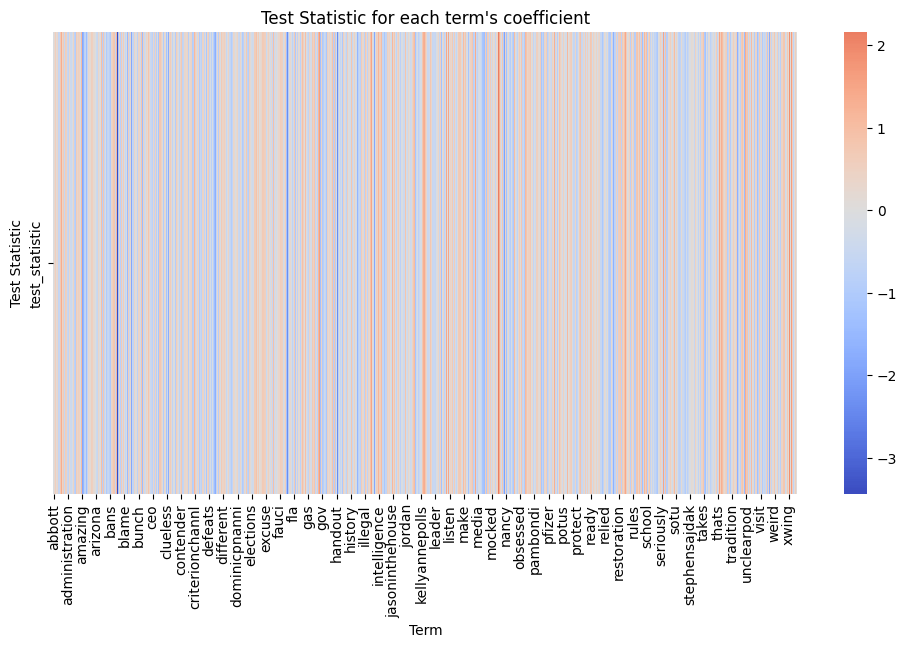

In [ ]:
import seaborn as sns

# Create a heatmap of the test statistics
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(coefs[['test_statistic']].transpose(), cmap='coolwarm', center=0, ax=ax)
ax.set_title('Test Statistic for each term\'s coefficient')
ax.set_xlabel('Term')
ax.set_ylabel('Test Statistic')
plt.show()


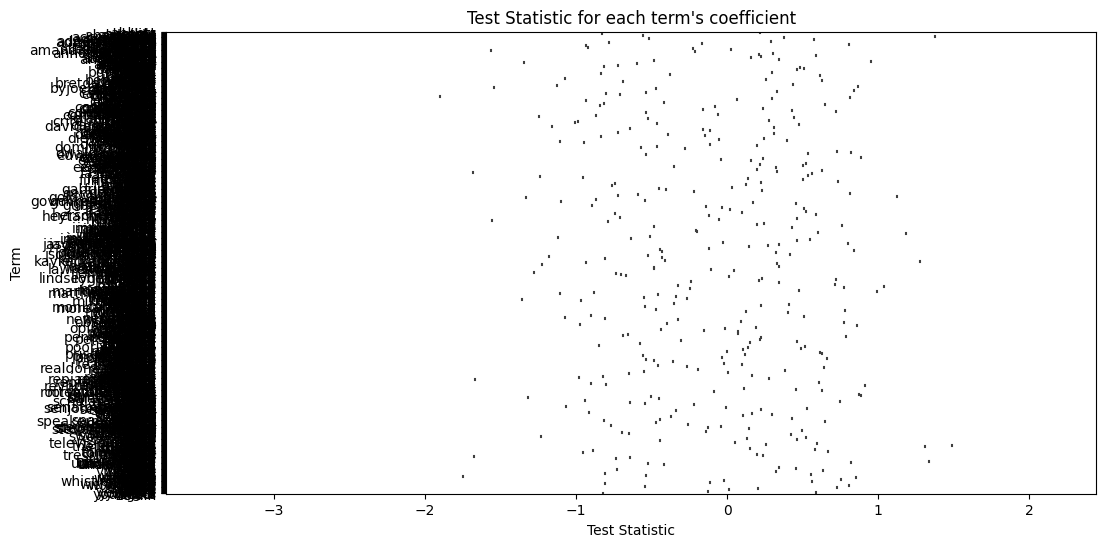

In [ ]:
# Create a violin plot of the test statistics
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(x='test_statistic', y='index', data=coefs.reset_index(), inner='quartile', palette=['C0', 'C1'])
ax.set_title('Test Statistic for each term\'s coefficient')
ax.set_xlabel('Test Statistic')
ax.set_ylabel('Term')
plt.show()


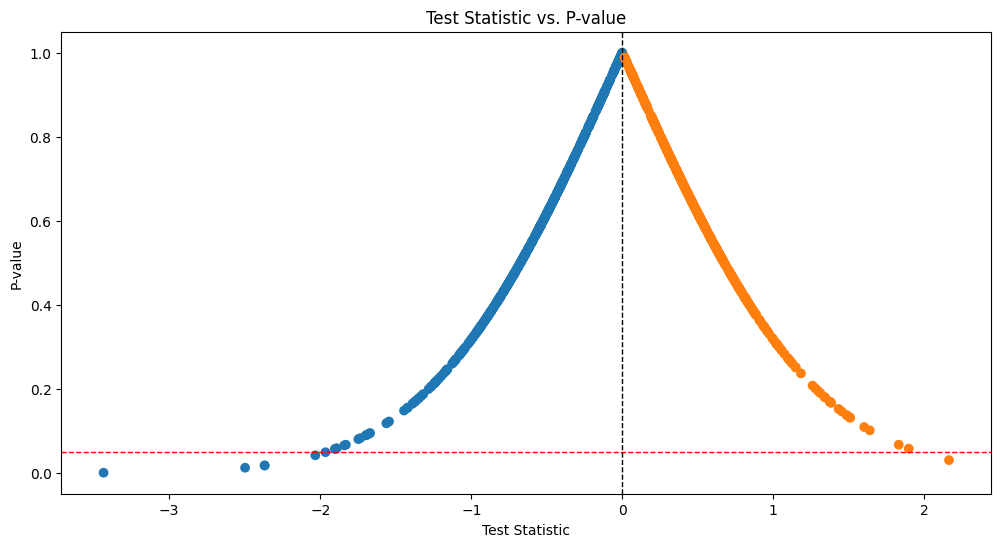

In [ ]:
# Create a scatter plot of the test statistics and p-values
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['C0' if x < 0 else 'C1' for x in coefs['test_statistic']]
ax.scatter(coefs['test_statistic'], coefs['p_value'], color=colors)
ax.axhline(y=0.05, color='r', linestyle='--', linewidth=1)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1)
ax.set_title('Test Statistic vs. P-value')
ax.set_xlabel('Test Statistic')
ax.set_ylabel('P-value')
plt.show()
